<font color="#e32b3d"><h1>Intent Classification</h2></font>

<font color="#822b34"><h2>*TREC Dataset*</h2></font>
<font color="#2ff9b3d"><h1>Part 2: Second Model - Main and Sub class classification </h1></font>

required library and packages are imported.

In [183]:
# Import library
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm


In [184]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [185]:
DIR_TRAIN = "/content/drive/MyDrive/TREC Dataset/train.csv"
DIR_TEST = "/content/drive/MyDrive/TREC Dataset/test.csv"

In [186]:
train_df = pd.read_csv(DIR_TRAIN)
test_df = pd.read_csv(DIR_TEST)
print('Train data set : '+str(train_df.shape[0]))
print('Test data set : '+str(test_df.shape[0]))

Train data set : 5452
Test data set : 500


In [187]:
coarse_classes = len(set(train_df["label-coarse"]))
fine_classes = len(set(train_df["label-fine"]))

coarse_labels=[]
for i in range(coarse_classes):
  coarse_labels.append(i) 
fine_labels=[]
for i in range(fine_classes):
  fine_labels.append(i) 

print('Coarse labels : '+str(coarse_classes))
print('Fine labels : '+str(fine_classes))

Coarse labels : 6
Fine labels : 47


In [188]:
from torchtext.vocab import GloVe
global_vectors = GloVe(name='6B', dim=300)
global_vectors

In [189]:
## tensor with size (1,300) with all zero elements for padding
colm_zero = torch.tensor([0 for i in range(300)]).to('cuda')

*tokenized* function to tokenize each sequence

In [190]:
from torchtext.data.utils import get_tokenizer
class tokenized ():
  def __init__(self, data):
    self.text = data[2]
    self.C_label = data[0]
    self.F_label = data[1]

  def Q_normalize (self):
    tokenizer = get_tokenizer("basic_english")
    lower = self.text.lower()
    ripped = lower.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'))
    token = tokenizer(ripped)
    return token, self.C_label, self.F_label
  

*vectorized* function to convert each word in a sequence to its corresponding tensor from *glove* dictionary

In [191]:
class vectorized ():
  def __init__(self, tokenized_Q):
    self.length = len(tokenized_Q)
    self.tokenized_Q = tokenized_Q
    self.l = []
    self.t = torch.empty((self.length,300), dtype=torch.float32)
  
  def data(self):
    for i in range(self.length):
      try: 
        idx = global_vectors.itos.index(self.tokenized_Q[i])
        self.l.append(global_vectors.vectors[idx].to('cuda'))
        self.t[i] = global_vectors.vectors[idx].to('cuda')
      except:
        ## if the word is not in the dictionary use paddings instead
        self.t[i] =colm_zero
        # print("the requested word is not in the dictionary")
        continue
    return self.t


Defining our own data structure, each train data will have the following structure:

        * 'coarse_label' : (1,6) tensor indicating the coarse label in a one hot manner
        * 'fine_label' : (1,47) tensor indicating the fine label in a one hot manner
        * 'data' : (seq_len, 300) tensor of converted sequence

In [192]:
## creating train the dataset 
train_dataset = []
for i in range(train_df.shape[0]):
  tewt, CL, FL = tokenized(train_df.values[i]).Q_normalize()
  data = vectorized(tewt).data().to('cuda')
  coarse_label = torch.empty((coarse_classes), dtype=torch.float32).to('cuda')
  fine_label = torch.empty((fine_classes), dtype=torch.float32).to('cuda')
  for i in range(coarse_classes):
    if (i == CL):
      coarse_label[i] = torch.tensor([1]).to('cuda')
    else: 
      coarse_label[i] = torch.tensor([0]).to('cuda')
  for i in range(fine_classes):
    if (i == FL):
      fine_label[i] = torch.tensor([1]).to('cuda')
    else: 
      fine_label[i] = torch.tensor([0]).to('cuda')
  m = {'coarse_label': coarse_label,
       'fine_label' : fine_label,
      'data':data}
  train_dataset.append(m)


In [193]:
## creating validation the dataset 
test_dataset = []
for i in range(test_df.shape[0]):
  tewt, CL, FL = tokenized(test_df.values[i]).Q_normalize()
  data = vectorized(tewt).data().to('cuda')
  coarse_label = torch.empty((coarse_classes), dtype=torch.float32).to('cuda')
  fine_label = torch.empty((fine_classes), dtype=torch.float32).to('cuda')
  for i in range(coarse_classes):
    if (i == CL):
      coarse_label[i] = torch.tensor([1]).to('cuda')
    else: 
      coarse_label[i] = torch.tensor([0]).to('cuda')
  for i in range(fine_classes):
    if (i == FL):
      fine_label[i] = torch.tensor([1]).to('cuda')
    else: 
      fine_label[i] = torch.tensor([0]).to('cuda')
  m = {'coarse_label': coarse_label,
       'fine_label' : fine_label,
      'data':data}
  test_dataset.append(m)

Samples of dataset:

In [194]:
train_dataset[9]

{'coarse_label': tensor([0., 0., 0., 1., 0., 0.], device='cuda:0'),
 'fine_label': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0'),
 'data': tensor([[-6.7224e-02,  2.4941e-02,  1.0431e-03,  ...,  7.2174e-02,
          -1.6984e-01,  3.6245e-01],
         [ 4.6560e-02,  2.1318e-01, -7.4364e-03,  ...,  9.0611e-03,
          -2.0989e-01,  5.3913e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 4.6560e-02,  2.1318e-01, -7.4364e-03,  ...,  9.0611e-03,
          -2.0989e-01,  5.3913e-02],
         [-3.7858e-01, -6.6782e-02, -3.7432e-01,  ..., -4.1964e-01,
          -8.0801e-01,  1.1245e+00],
         [-4.4975e-02, -3.8301e-01, -1.9541e-01,  ..., -6.1190e-01,
          -7.2234e-02,  1.5600e-01]], device='cuda:0')}

Finding the maximum sequence length:

In [195]:
# maximum sentence length in train dataset
length =[]
for i in range(train_df.shape[0]):
  length.append(train_dataset[i]["data"].shape[0])
max_len = max(length)
max_len

34

padding each sequence so that all the suqences have the matching length of *max_len*

As stated in the paper, another padding must be added to the end of the sequnce.

In [196]:
# padding with zero tensors 
##  Adding the last PAD element
pad = torch.empty((1,300), dtype=torch.int64).to('cuda')
pad[0] = colm_zero
for i in range(train_df.shape[0]):
  if(train_dataset[i]['data'].shape[0]<=max_len):
    temp = torch.empty((max_len-train_dataset[i]['data'].shape[0],300), dtype=torch.int64).to('cuda')
    for k in range(max_len-train_dataset[i]['data'].shape[0]):
      temp[k] = colm_zero
    train_dataset[i]['data'] = torch.cat((temp, train_dataset[i]['data'],pad), 0)


for i in range(test_df.shape[0]):
  if(test_dataset[i]['data'].shape[0]<=max_len):
    temp = torch.empty((max_len-test_dataset[i]['data'].shape[0],300), dtype=torch.int64).to('cuda')
    for k in range(max_len-test_dataset[i]['data'].shape[0]):
      temp[k] = colm_zero
    test_dataset[i]['data'] = torch.cat((temp, test_dataset[i]['data'],pad), 0)

checking the length of sequencs in both datasets:

In [197]:
## sample of train padded data
print(train_dataset[2661]['data'].shape)
## sample of validation padded data
print(test_dataset[2]['data'].shape)

torch.Size([35, 300])
torch.Size([35, 300])


Creating dataloaders:

In [198]:
## creating dataloaders
batch_size = 4
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size =batch_size,
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size =batch_size,
    shuffle = True
)

In [199]:
class LSTM(nn.Module):

    def __init__(self, dimension):
        super(LSTM, self).__init__()
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)
        self.dropout1 = nn.Dropout(p=0.3)
        self.sigmoid = nn.Sigmoid()
        self.coarse_linear = nn.Linear(dimension, coarse_classes)
        self.fine_linear = nn.Linear(dimension, fine_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, text):
        out, (hidden_state,cell_state) = self.lstm(text)

        out = self.dropout1( out) 

        fine = self.sigmoid(out[:, -1, :])
        fine = self.fine_linear(fine)
        fine_soft = self.softmax(fine)

        coarse = self.sigmoid(out[:, -2, :])
        coarse = self.coarse_linear(coarse)
        coarse_soft = self.softmax(coarse)

        return coarse_soft, fine_soft
        


Definfing the accuracy function:

In [200]:
def accuracy_fn(true, pred):
  acc = 0.0000
  for i in range(true.shape[0]):
    if (true[i].detach().cpu().numpy().argmax() == pred[i].detach().cpu().numpy().argmax()):
      acc+=1
    else:
      acc+=0
  return acc/true.shape[0]

Fit function will be called at each epoch:

In [201]:
def fit(model, train_dataloader, optimizer, criterion):
    model.train()   # Training mode (allow weight updates)
    train_running_loss_coarse = 0.0
    train_running_loss_fine = 0.0

    train_running_acc_coarse = 0.0
    train_running_acc_fine = 0.0
    counter = 0
    train_loss = 0.0

    train_acc_coarse = 0.0
    train_acc_fine = 0.0

    with tqdm(train_dataloader, desc ="  train") as train_tqdm:
      for item in train_tqdm:
        counter += 1
        data = item['data'].to('cuda')
        coarse_label = item['coarse_label'].to('cuda')
        fine_label = item['fine_label'].to('cuda')

        optimizer.zero_grad()   # Reset gradients
        coarse_out, fine_out = model(data.to('cuda'))   # Calculate outputs using the model
        
        loss_coarse = criterion(coarse_out, coarse_label)     ## Calculate Coarse Loss
        train_running_loss_coarse += loss_coarse.item()

        loss_fine = criterion(fine_out, fine_label)     ## Calculate Fine Loss
        train_running_loss_fine += loss_fine.item()

        total_loss = loss_coarse + loss_fine

        total_loss.backward()   ## Backpropage the loss and calculate the gradients

        # calculate accuracies
        coarse_acc = accuracy_fn(coarse_label, coarse_out)
        fine_acc = accuracy_fn(fine_label, fine_out)

        train_running_acc_coarse += coarse_acc
        train_running_acc_fine += fine_acc

        optimizer.step()  ## Update the weights using backpropagation

        train_tqdm.set_postfix(train_acc_coarse="{:.3f}".format(train_running_acc_coarse/counter),
                               train_acc_fine="{:.3f}".format(train_running_acc_fine/counter), 
                               train_loss_coarse=train_running_loss_coarse/counter, 
                               train_loss_fine=train_running_loss_fine/counter, refresh=False)

    train_loss = total_loss / counter ## Total epoch loss
    train_loss_coarse = train_running_loss_coarse / counter ## coarse epoch loss
    train_loss_fine = train_running_loss_fine / counter ## fine epoch loss
    train_acc_coarse = train_running_acc_coarse / counter ## coarse epoch acc
    train_acc_fine = train_running_acc_fine / counter ## fine epoch acc
    return train_loss_coarse, train_acc_coarse, train_loss_fine, train_acc_fine

In [202]:
def validation(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_running_loss_coarse = 0.0
    val_running_loss_fine = 0.0

    val_running_acc_coarse = 0.0
    val_running_acc_fine = 0.0

    counter = 0
    val_lossval_loss_coarse = 0.0
    val_acc_coarse = 0.0
    val_loss_fine = 0.0
    val_acc_fine = 0.0
    
    with tqdm(data_loader, desc ="  test") as test_tqdm:
      for item in test_tqdm:
        counter += 1
        data = item['data'].to('cuda')
        coarse_label = item['coarse_label'].to('cuda')
        fine_label = item['fine_label'].to('cuda')
        coarse_out, fine_out = model(data.to('cuda'))   # Calculate outputs using the model

        loss_coarse = criterion(coarse_out, coarse_label)     ## Calculate Coarse Loss
        val_running_loss_coarse += loss_coarse.item()

        loss_fine = criterion(fine_out, fine_label)     ## Calculate Fine Loss
        val_running_loss_fine += loss_fine.item()

        total_loss = loss_coarse + loss_fine    ## Calculate Loss

        coarse_acc = accuracy_fn(coarse_label, coarse_out)
        fine_acc = accuracy_fn(fine_label, fine_out)

        val_running_acc_coarse += coarse_acc
        val_running_acc_fine += fine_acc

        test_tqdm.set_postfix(val_acc_coarse="{:.3f}".format(val_running_acc_coarse/counter),
                                val_acc_fine="{:.3f}".format(val_running_acc_fine/counter), 
                                val_loss_coarse=val_running_loss_coarse/counter, 
                                val_loss_fine=val_running_loss_fine/counter, refresh=False)
        
    val_loss_coarse = val_running_loss_coarse / counter ## Coarse epoch loss
    val_acc_coarse = val_running_acc_coarse / counter ## Coarse epoch acc
    val_loss_fine = val_running_loss_fine / counter ## Fine epoch loss
    val_acc_fine = val_running_acc_fine / counter ## Fine epoch acc
    return val_loss_coarse, val_acc_coarse, val_loss_fine, val_acc_fine

<font color="#AF3B54"><h2>*Training with 25 hidden layes*</h2></font>


Training with 25 hidden layers for 100 epochs:

In [223]:
import torch.optim as optim
model25 = LSTM(dimension = 25).to('cuda')
## Optimizer and loss function
optimizer = optim.Adam(model25.parameters(),lr=0.001)
criterion = nn.BCELoss()

train_loss_coarse = []
train_loss_fine = []
train_acc_coarse = []
train_acc_fine = []

val_loss_coarse = []
val_loss_fine = []
val_acc_coarse = []
val_acc_fine = []

epochs = 100
for epoch in range(epochs):
  print("EPOCH {}/{} :".format(epoch +1, epochs))
  ## fit
  train_epoch_loss_coarse , train_epoch_acc_coarse, train_epoch_loss_fine, train_epoch_acc_fine= fit(model25, train_dataloader, optimizer, criterion)
  train_loss_coarse.append(train_epoch_loss_coarse)
  train_acc_coarse.append(train_epoch_acc_coarse)
  train_loss_fine.append(train_epoch_loss_fine)
  train_acc_fine.append(train_epoch_acc_fine)
  ## Validation
  val_epoch_loss_coarse, val_epoch_acc_coarse, val_epoch_loss_fine, val_epoch_acc_fine= validation(model25, test_dataloader, criterion)
  val_loss_coarse.append(val_epoch_loss_coarse)
  val_acc_coarse.append(val_epoch_acc_coarse)
  val_loss_fine.append(val_epoch_loss_fine)
  val_acc_fine.append(val_epoch_acc_fine)

torch.save(model25.state_dict(), 'second_trained_model_25')

EPOCH 1/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 715.29it/s, val_acc_coarse=0.602, val_acc_fine=0.224, val_loss_coarse=0.314, val_loss_fine=0.0842]


EPOCH 2/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 671.31it/s, val_acc_coarse=0.800, val_acc_fine=0.476, val_loss_coarse=0.225, val_loss_fine=0.0774]


EPOCH 3/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 500.79it/s, val_acc_coarse=0.890, val_acc_fine=0.476, val_loss_coarse=0.158, val_loss_fine=0.0746]


EPOCH 4/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 702.95it/s, val_acc_coarse=0.894, val_acc_fine=0.458, val_loss_coarse=0.129, val_loss_fine=0.0725]


EPOCH 5/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 703.38it/s, val_acc_coarse=0.876, val_acc_fine=0.476, val_loss_coarse=0.13, val_loss_fine=0.0696]


EPOCH 6/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 732.93it/s, val_acc_coarse=0.886, val_acc_fine=0.470, val_loss_coarse=0.108, val_loss_fine=0.0675]


EPOCH 7/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 691.40it/s, val_acc_coarse=0.876, val_acc_fine=0.466, val_loss_coarse=0.115, val_loss_fine=0.0663]


EPOCH 8/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 680.83it/s, val_acc_coarse=0.900, val_acc_fine=0.462, val_loss_coarse=0.101, val_loss_fine=0.0646]


EPOCH 9/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 684.68it/s, val_acc_coarse=0.896, val_acc_fine=0.470, val_loss_coarse=0.104, val_loss_fine=0.0632]


EPOCH 10/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 700.12it/s, val_acc_coarse=0.894, val_acc_fine=0.472, val_loss_coarse=0.0937, val_loss_fine=0.0621]


EPOCH 11/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 512.31it/s, val_acc_coarse=0.888, val_acc_fine=0.480, val_loss_coarse=0.103, val_loss_fine=0.0622]


EPOCH 12/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 689.84it/s, val_acc_coarse=0.880, val_acc_fine=0.470, val_loss_coarse=0.125, val_loss_fine=0.0627]


EPOCH 13/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 684.76it/s, val_acc_coarse=0.902, val_acc_fine=0.464, val_loss_coarse=0.104, val_loss_fine=0.0606]


EPOCH 14/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 533.62it/s, val_acc_coarse=0.908, val_acc_fine=0.470, val_loss_coarse=0.0973, val_loss_fine=0.0608]


EPOCH 15/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 725.77it/s, val_acc_coarse=0.906, val_acc_fine=0.476, val_loss_coarse=0.102, val_loss_fine=0.0604]


EPOCH 16/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 694.06it/s, val_acc_coarse=0.892, val_acc_fine=0.466, val_loss_coarse=0.103, val_loss_fine=0.0607]


EPOCH 17/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 529.53it/s, val_acc_coarse=0.904, val_acc_fine=0.466, val_loss_coarse=0.0995, val_loss_fine=0.0597]


EPOCH 18/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 683.49it/s, val_acc_coarse=0.894, val_acc_fine=0.466, val_loss_coarse=0.115, val_loss_fine=0.0603]


EPOCH 19/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 700.53it/s, val_acc_coarse=0.904, val_acc_fine=0.478, val_loss_coarse=0.094, val_loss_fine=0.0592]


EPOCH 20/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 705.89it/s, val_acc_coarse=0.896, val_acc_fine=0.454, val_loss_coarse=0.0964, val_loss_fine=0.0602]


EPOCH 21/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 702.85it/s, val_acc_coarse=0.896, val_acc_fine=0.474, val_loss_coarse=0.0987, val_loss_fine=0.0594]


EPOCH 22/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 672.84it/s, val_acc_coarse=0.898, val_acc_fine=0.470, val_loss_coarse=0.104, val_loss_fine=0.0593]


EPOCH 23/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 648.21it/s, val_acc_coarse=0.894, val_acc_fine=0.476, val_loss_coarse=0.114, val_loss_fine=0.0598]


EPOCH 24/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 711.83it/s, val_acc_coarse=0.902, val_acc_fine=0.526, val_loss_coarse=0.0942, val_loss_fine=0.0573]


EPOCH 25/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 503.06it/s, val_acc_coarse=0.890, val_acc_fine=0.480, val_loss_coarse=0.107, val_loss_fine=0.0584]


EPOCH 26/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 694.17it/s, val_acc_coarse=0.888, val_acc_fine=0.544, val_loss_coarse=0.109, val_loss_fine=0.0579]


EPOCH 27/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 704.28it/s, val_acc_coarse=0.904, val_acc_fine=0.498, val_loss_coarse=0.106, val_loss_fine=0.0603]


EPOCH 28/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 406.41it/s, val_acc_coarse=0.890, val_acc_fine=0.516, val_loss_coarse=0.1, val_loss_fine=0.0583] 


EPOCH 29/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 720.04it/s, val_acc_coarse=0.900, val_acc_fine=0.558, val_loss_coarse=0.11, val_loss_fine=0.0562]


EPOCH 30/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 708.82it/s, val_acc_coarse=0.904, val_acc_fine=0.558, val_loss_coarse=0.103, val_loss_fine=0.0565]


EPOCH 31/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 134.21it/s, val_acc_coarse=0.904, val_acc_fine=0.568, val_loss_coarse=0.108, val_loss_fine=0.0561]


EPOCH 32/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 709.08it/s, val_acc_coarse=0.908, val_acc_fine=0.572, val_loss_coarse=0.104, val_loss_fine=0.0546]


EPOCH 33/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 701.56it/s, val_acc_coarse=0.896, val_acc_fine=0.570, val_loss_coarse=0.116, val_loss_fine=0.0552]


EPOCH 34/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 705.51it/s, val_acc_coarse=0.904, val_acc_fine=0.580, val_loss_coarse=0.112, val_loss_fine=0.0552]


EPOCH 35/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 714.55it/s, val_acc_coarse=0.906, val_acc_fine=0.552, val_loss_coarse=0.125, val_loss_fine=0.0559]


EPOCH 36/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 679.04it/s, val_acc_coarse=0.906, val_acc_fine=0.566, val_loss_coarse=0.119, val_loss_fine=0.0544]


EPOCH 37/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 675.55it/s, val_acc_coarse=0.898, val_acc_fine=0.560, val_loss_coarse=0.11, val_loss_fine=0.0542]


EPOCH 38/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 698.75it/s, val_acc_coarse=0.898, val_acc_fine=0.574, val_loss_coarse=0.124, val_loss_fine=0.0532]


EPOCH 39/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 527.52it/s, val_acc_coarse=0.898, val_acc_fine=0.576, val_loss_coarse=0.129, val_loss_fine=0.0533]


EPOCH 40/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 711.11it/s, val_acc_coarse=0.896, val_acc_fine=0.562, val_loss_coarse=0.114, val_loss_fine=0.053]


EPOCH 41/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 720.97it/s, val_acc_coarse=0.904, val_acc_fine=0.568, val_loss_coarse=0.121, val_loss_fine=0.0533]


EPOCH 42/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 709.37it/s, val_acc_coarse=0.886, val_acc_fine=0.516, val_loss_coarse=0.156, val_loss_fine=0.057]


EPOCH 43/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 695.33it/s, val_acc_coarse=0.888, val_acc_fine=0.556, val_loss_coarse=0.131, val_loss_fine=0.0525]


EPOCH 44/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 653.87it/s, val_acc_coarse=0.914, val_acc_fine=0.574, val_loss_coarse=0.105, val_loss_fine=0.0509]


EPOCH 45/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 674.74it/s, val_acc_coarse=0.908, val_acc_fine=0.568, val_loss_coarse=0.103, val_loss_fine=0.0513]


EPOCH 46/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 697.55it/s, val_acc_coarse=0.908, val_acc_fine=0.572, val_loss_coarse=0.104, val_loss_fine=0.0511]


EPOCH 47/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 540.01it/s, val_acc_coarse=0.906, val_acc_fine=0.558, val_loss_coarse=0.12, val_loss_fine=0.0515] 


EPOCH 48/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 721.07it/s, val_acc_coarse=0.904, val_acc_fine=0.568, val_loss_coarse=0.119, val_loss_fine=0.0507]


EPOCH 49/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 688.63it/s, val_acc_coarse=0.916, val_acc_fine=0.580, val_loss_coarse=0.108, val_loss_fine=0.0496]


EPOCH 50/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 435.11it/s, val_acc_coarse=0.898, val_acc_fine=0.570, val_loss_coarse=0.117, val_loss_fine=0.0508]


EPOCH 51/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 392.98it/s, val_acc_coarse=0.914, val_acc_fine=0.576, val_loss_coarse=0.103, val_loss_fine=0.0489]


EPOCH 52/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 490.72it/s, val_acc_coarse=0.908, val_acc_fine=0.582, val_loss_coarse=0.108, val_loss_fine=0.0483]


EPOCH 53/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 673.39it/s, val_acc_coarse=0.910, val_acc_fine=0.582, val_loss_coarse=0.103, val_loss_fine=0.0476]


EPOCH 54/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 709.94it/s, val_acc_coarse=0.916, val_acc_fine=0.576, val_loss_coarse=0.109, val_loss_fine=0.0482]


EPOCH 55/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 694.73it/s, val_acc_coarse=0.914, val_acc_fine=0.584, val_loss_coarse=0.114, val_loss_fine=0.0484]


EPOCH 56/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 645.79it/s, val_acc_coarse=0.908, val_acc_fine=0.578, val_loss_coarse=0.122, val_loss_fine=0.0475]


EPOCH 57/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 707.05it/s, val_acc_coarse=0.914, val_acc_fine=0.600, val_loss_coarse=0.102, val_loss_fine=0.0466]


EPOCH 58/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 696.39it/s, val_acc_coarse=0.898, val_acc_fine=0.562, val_loss_coarse=0.123, val_loss_fine=0.0488]


EPOCH 59/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 671.27it/s, val_acc_coarse=0.910, val_acc_fine=0.582, val_loss_coarse=0.103, val_loss_fine=0.0472]


EPOCH 60/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 524.66it/s, val_acc_coarse=0.908, val_acc_fine=0.578, val_loss_coarse=0.111, val_loss_fine=0.0463]


EPOCH 61/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 688.16it/s, val_acc_coarse=0.908, val_acc_fine=0.586, val_loss_coarse=0.112, val_loss_fine=0.0463]


EPOCH 62/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 650.48it/s, val_acc_coarse=0.894, val_acc_fine=0.586, val_loss_coarse=0.13, val_loss_fine=0.0457]


EPOCH 63/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 475.98it/s, val_acc_coarse=0.910, val_acc_fine=0.586, val_loss_coarse=0.115, val_loss_fine=0.0459]


EPOCH 64/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 709.12it/s, val_acc_coarse=0.894, val_acc_fine=0.586, val_loss_coarse=0.142, val_loss_fine=0.0466]


EPOCH 65/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 660.07it/s, val_acc_coarse=0.902, val_acc_fine=0.590, val_loss_coarse=0.132, val_loss_fine=0.0471]


EPOCH 66/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 718.73it/s, val_acc_coarse=0.912, val_acc_fine=0.588, val_loss_coarse=0.123, val_loss_fine=0.0461]


EPOCH 67/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 708.97it/s, val_acc_coarse=0.906, val_acc_fine=0.570, val_loss_coarse=0.114, val_loss_fine=0.0474]


EPOCH 68/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 670.26it/s, val_acc_coarse=0.906, val_acc_fine=0.590, val_loss_coarse=0.121, val_loss_fine=0.0457]


EPOCH 69/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 669.27it/s, val_acc_coarse=0.904, val_acc_fine=0.592, val_loss_coarse=0.13, val_loss_fine=0.0457]


EPOCH 70/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 678.62it/s, val_acc_coarse=0.892, val_acc_fine=0.586, val_loss_coarse=0.126, val_loss_fine=0.0456]


EPOCH 71/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 499.40it/s, val_acc_coarse=0.906, val_acc_fine=0.596, val_loss_coarse=0.135, val_loss_fine=0.0453]


EPOCH 72/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 646.57it/s, val_acc_coarse=0.902, val_acc_fine=0.604, val_loss_coarse=0.151, val_loss_fine=0.0449]


EPOCH 73/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 700.73it/s, val_acc_coarse=0.920, val_acc_fine=0.600, val_loss_coarse=0.116, val_loss_fine=0.0438]


EPOCH 74/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 590.39it/s, val_acc_coarse=0.892, val_acc_fine=0.584, val_loss_coarse=0.162, val_loss_fine=0.0466]


EPOCH 75/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 681.44it/s, val_acc_coarse=0.894, val_acc_fine=0.570, val_loss_coarse=0.151, val_loss_fine=0.0475]


EPOCH 76/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 716.12it/s, val_acc_coarse=0.892, val_acc_fine=0.598, val_loss_coarse=0.136, val_loss_fine=0.0449]


EPOCH 77/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 704.70it/s, val_acc_coarse=0.900, val_acc_fine=0.600, val_loss_coarse=0.126, val_loss_fine=0.0448]


EPOCH 78/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 661.15it/s, val_acc_coarse=0.908, val_acc_fine=0.598, val_loss_coarse=0.146, val_loss_fine=0.0445]


EPOCH 79/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 613.94it/s, val_acc_coarse=0.904, val_acc_fine=0.590, val_loss_coarse=0.128, val_loss_fine=0.0444]


EPOCH 80/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 645.11it/s, val_acc_coarse=0.904, val_acc_fine=0.580, val_loss_coarse=0.141, val_loss_fine=0.0465]


EPOCH 81/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 671.07it/s, val_acc_coarse=0.900, val_acc_fine=0.580, val_loss_coarse=0.14, val_loss_fine=0.0473]


EPOCH 82/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 545.21it/s, val_acc_coarse=0.910, val_acc_fine=0.610, val_loss_coarse=0.118, val_loss_fine=0.044] 


EPOCH 83/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 707.75it/s, val_acc_coarse=0.912, val_acc_fine=0.594, val_loss_coarse=0.136, val_loss_fine=0.0441]


EPOCH 84/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 654.60it/s, val_acc_coarse=0.886, val_acc_fine=0.584, val_loss_coarse=0.15, val_loss_fine=0.0448]


EPOCH 85/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 449.68it/s, val_acc_coarse=0.904, val_acc_fine=0.584, val_loss_coarse=0.136, val_loss_fine=0.044]


EPOCH 86/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 710.91it/s, val_acc_coarse=0.912, val_acc_fine=0.592, val_loss_coarse=0.139, val_loss_fine=0.0433]


EPOCH 87/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 694.53it/s, val_acc_coarse=0.884, val_acc_fine=0.588, val_loss_coarse=0.17, val_loss_fine=0.0449]


EPOCH 88/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 477.72it/s, val_acc_coarse=0.902, val_acc_fine=0.590, val_loss_coarse=0.14, val_loss_fine=0.0441] 


EPOCH 89/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 684.91it/s, val_acc_coarse=0.894, val_acc_fine=0.588, val_loss_coarse=0.15, val_loss_fine=0.0441]


EPOCH 90/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 699.41it/s, val_acc_coarse=0.902, val_acc_fine=0.590, val_loss_coarse=0.147, val_loss_fine=0.0439]


EPOCH 91/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 659.33it/s, val_acc_coarse=0.896, val_acc_fine=0.590, val_loss_coarse=0.151, val_loss_fine=0.0449]


EPOCH 92/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 717.28it/s, val_acc_coarse=0.908, val_acc_fine=0.582, val_loss_coarse=0.153, val_loss_fine=0.0443]


EPOCH 93/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 718.47it/s, val_acc_coarse=0.894, val_acc_fine=0.602, val_loss_coarse=0.144, val_loss_fine=0.0438]


EPOCH 94/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 711.34it/s, val_acc_coarse=0.906, val_acc_fine=0.598, val_loss_coarse=0.144, val_loss_fine=0.0428]


EPOCH 95/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 693.84it/s, val_acc_coarse=0.902, val_acc_fine=0.618, val_loss_coarse=0.158, val_loss_fine=0.0439]


EPOCH 96/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 487.40it/s, val_acc_coarse=0.898, val_acc_fine=0.624, val_loss_coarse=0.159, val_loss_fine=0.0435]


EPOCH 97/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 685.75it/s, val_acc_coarse=0.904, val_acc_fine=0.620, val_loss_coarse=0.146, val_loss_fine=0.0442]


EPOCH 98/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 692.79it/s, val_acc_coarse=0.900, val_acc_fine=0.594, val_loss_coarse=0.171, val_loss_fine=0.0445]


EPOCH 99/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 482.97it/s, val_acc_coarse=0.904, val_acc_fine=0.604, val_loss_coarse=0.155, val_loss_fine=0.0431]


EPOCH 100/100 :


  test: 100%|██████████| 125/125 [00:00<00:00, 722.16it/s, val_acc_coarse=0.910, val_acc_fine=0.598, val_loss_coarse=0.143, val_loss_fine=0.0432]


*plot_acc_loss* function plots accuracy and loss values for train and validation per epoch

In [224]:
import matplotlib.pyplot as plt
def plot_acc_loss(train_acc, val_acc, train_loss, val_loss, hidden, name):
  fig, axs = plt.subplots(2, figsize=(15,10))
  ## Plotting the training acc and validation acc vs epochs
  axs[0].plot(list(range(1,len(train_acc)+1)), train_acc, label='Train Acc', linewidth=4)
  axs[0].plot(list(range(1,len(val_acc)+1)), val_acc, label='Val Acc', linewidth=4)
  axs[0].set_title(str(name)+' Accuracy per Epoch for First Model with hidden_layer = '+str(hidden))
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].grid()
  axs[0].legend()
  ## Plotting the training loss and validation loss vs epochs
  axs[1].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss', linewidth=4)
  axs[1].plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss', linewidth=4)
  axs[1].set_title(str(name)+' Loss per Epoch for First Model with hidden_layer = '+str(hidden))
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].grid()
  axs[1].legend()
  plt.tight_layout()

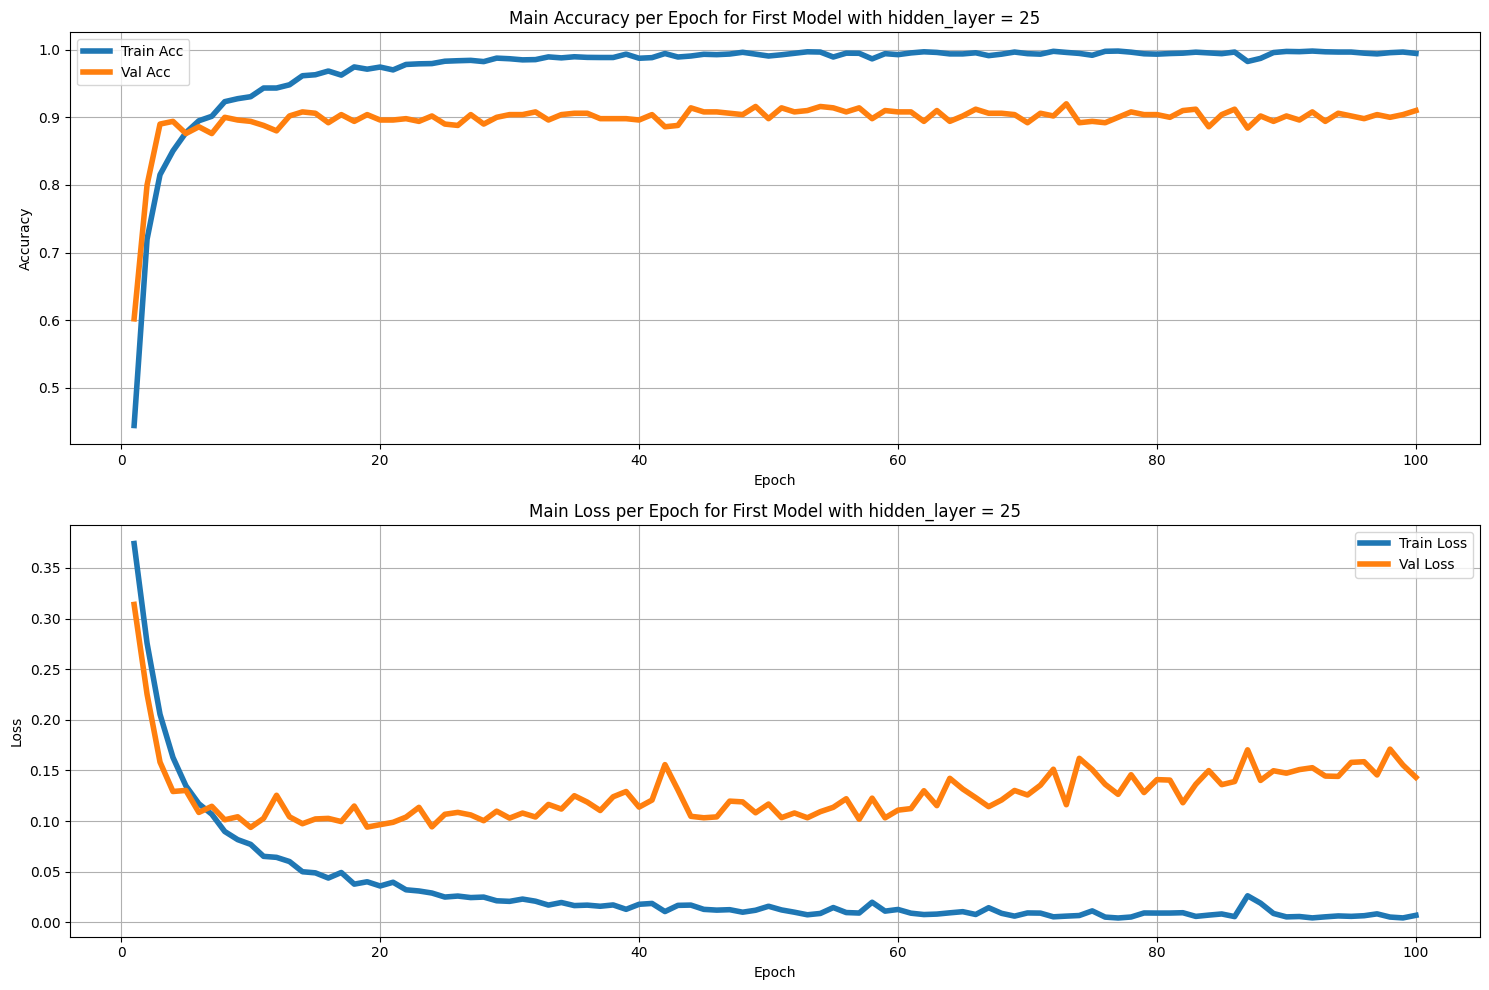

In [225]:
# Main classification
plot_acc_loss(train_acc_coarse, val_acc_coarse, train_loss_coarse, val_loss_coarse, 25, 'Main')

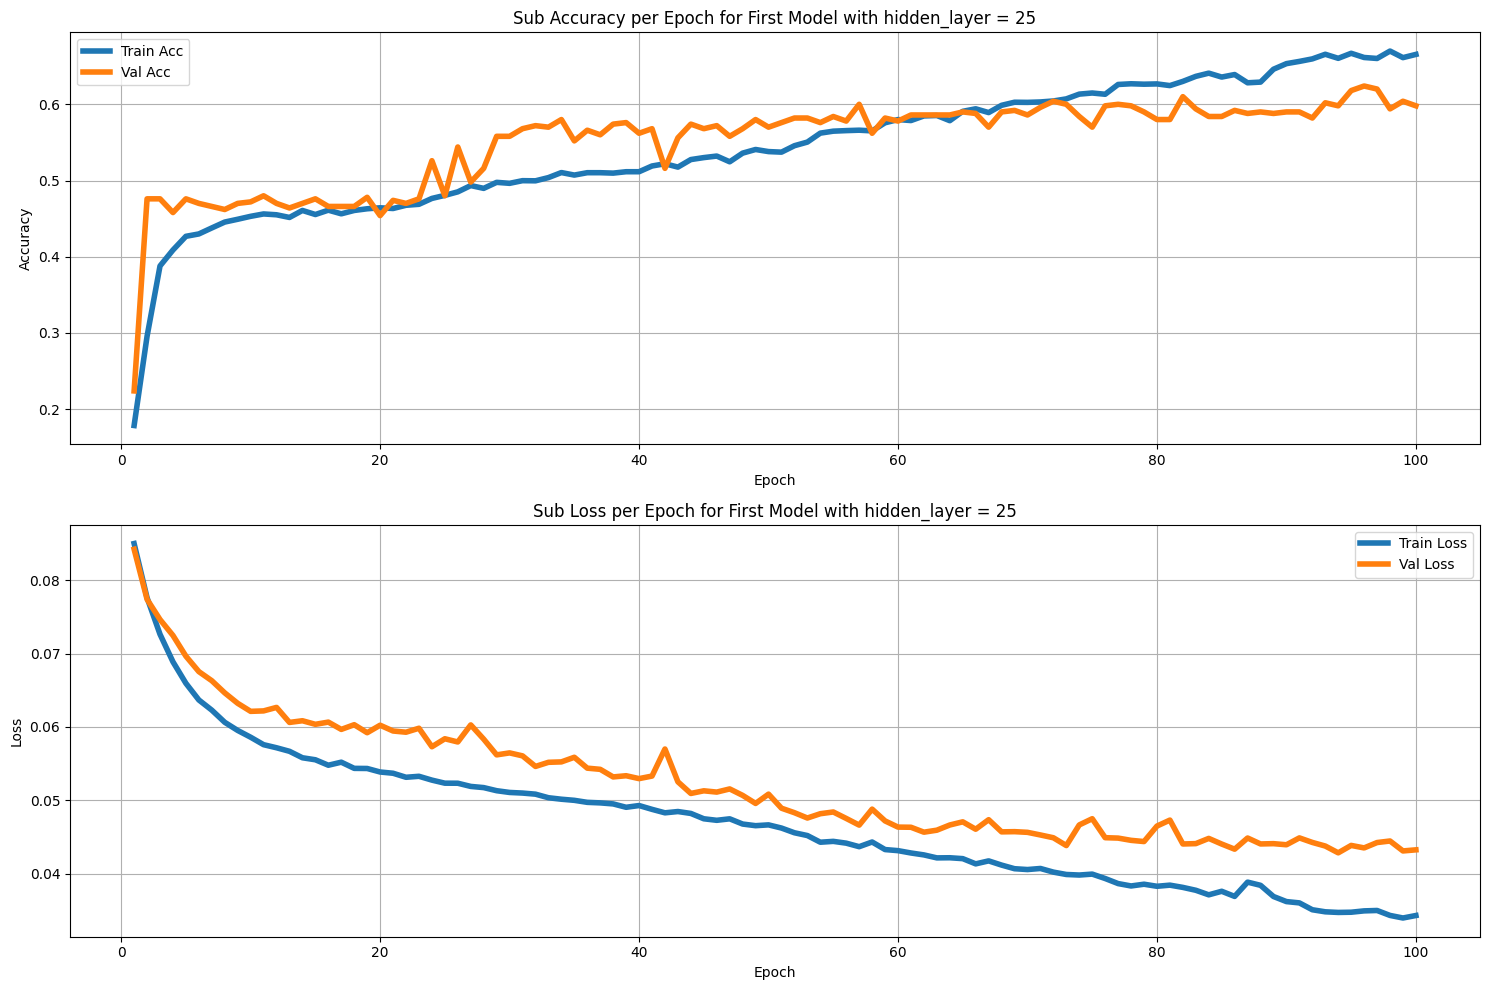

In [226]:
# Sub classification
plot_acc_loss(train_acc_fine, val_acc_fine, train_loss_fine, val_loss_fine, 25, 'Sub')

*conf_acc* function plots confusion matrix and reports classification metrics such as f1-score, percision, recall and accuracy

In [227]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def conf_acc(y_true, y_pred, Attr, hidden):
  cnf_matrix = confusion_matrix(y_true, y_pred)   ## Sklearn confusion matrix object
  accuracy = np.trace(cnf_matrix) / float(np.sum(cnf_matrix))
  misclass = 1 - accuracy

  fig, ax = plt.subplots(figsize=(10, 10))
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap = "Blues" ,fmt='g')
  ax.xaxis.set_label_position("bottom")
  plt.title('Confusion matrix for ' + str(Attr)+' class of second model with hidden_layer = '+str(hidden), y=1.1)
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
  plt.tight_layout()
  print(classification_report(y_true, y_pred, digits=4))


*Testing* function feeds the trained network with test_dataloader and using *conf_acc* reports the results

In [228]:
def Testing(model, data_loader, hidden):

  counter = 0

  test_acc_coarse = 0.0
  test_acc_fine = 0.0
  
  y_true_coarse = []
  y_true_fine = []
  y_pred_coarse = []
  y_pred_fine = []
  # Send model to GPU
  device = torch.device("cuda")
  model.load_state_dict(torch.load('second_trained_model_'+str(hidden)))
  model.to(device)

  model.eval() 

  with tqdm(data_loader, desc ="   test") as test_tqdm:
    for item in test_tqdm:
      data = item['data'].to('cuda')
      coarse_label = item['coarse_label'].to('cuda')
      fine_label = item['fine_label'].to('cuda')
      coarse_out, fine_out = model(data.to('cuda'))   # Calculate outputs using the model

      for i in range (coarse_label.shape[0]):
        y_true_coarse.append((coarse_label[i].detach().cpu().numpy()).argmax()) 
        y_pred_coarse.append((coarse_out[i].detach().cpu().numpy()).argmax())

      for i in range (fine_label.shape[0]):
        y_true_fine.append((fine_label[i].detach().cpu().numpy()).argmax()) 
        y_pred_fine.append((fine_out[i].detach().cpu().numpy()).argmax())

  ## plot coonfusion matrix
  conf_acc(y_true_coarse, y_pred_coarse, 'Main', hidden)
  conf_acc(y_true_fine, y_pred_fine, 'Sub', hidden)

  return

   

   test: 100%|██████████| 125/125 [00:00<00:00, 583.75it/s]


              precision    recall  f1-score   support

           0     0.8516    0.9565    0.9010       138
           1     0.9114    0.7660    0.8324        94
           2     0.8750    0.7778    0.8235         9
           3     0.9242    0.9385    0.9313        65
           4     0.9813    0.9292    0.9545       113
           5     0.9176    0.9630    0.9398        81

    accuracy                         0.9100       500
   macro avg     0.9102    0.8885    0.8971       500
weighted avg     0.9127    0.9100    0.9090       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0     0.2000    1.0000    0.3333         2
           1     0.0000    0.0000    0.0000         0
           2     0.0000    0.0000    0.0000        16
           3     0.6667    0.7500    0.7059         8
           4     0.8525    0.9455    0.8966        55
           5     0.2222    0.3333    0.2667         6
           6     0.0000    0.0000    0.0000         1
           7     0.8540    0.9512    0.9000       123
           8     0.9400    1.0000    0.9691        47
           9     0.0000    0.0000    0.0000         6
          10     0.0000    0.0000    0.0000         2
          11     0.0000    0.0000    0.0000         7
          12     0.3000    0.3000    0.3000        10
          13     0.2812    1.0000    0.4390         9
          14     0.5340    0.7432    0.6215        74
          17     0.0000    0.0000    0.0000         4
          18     0.1154    1.0000    0.2069         3
          19     0.0000    

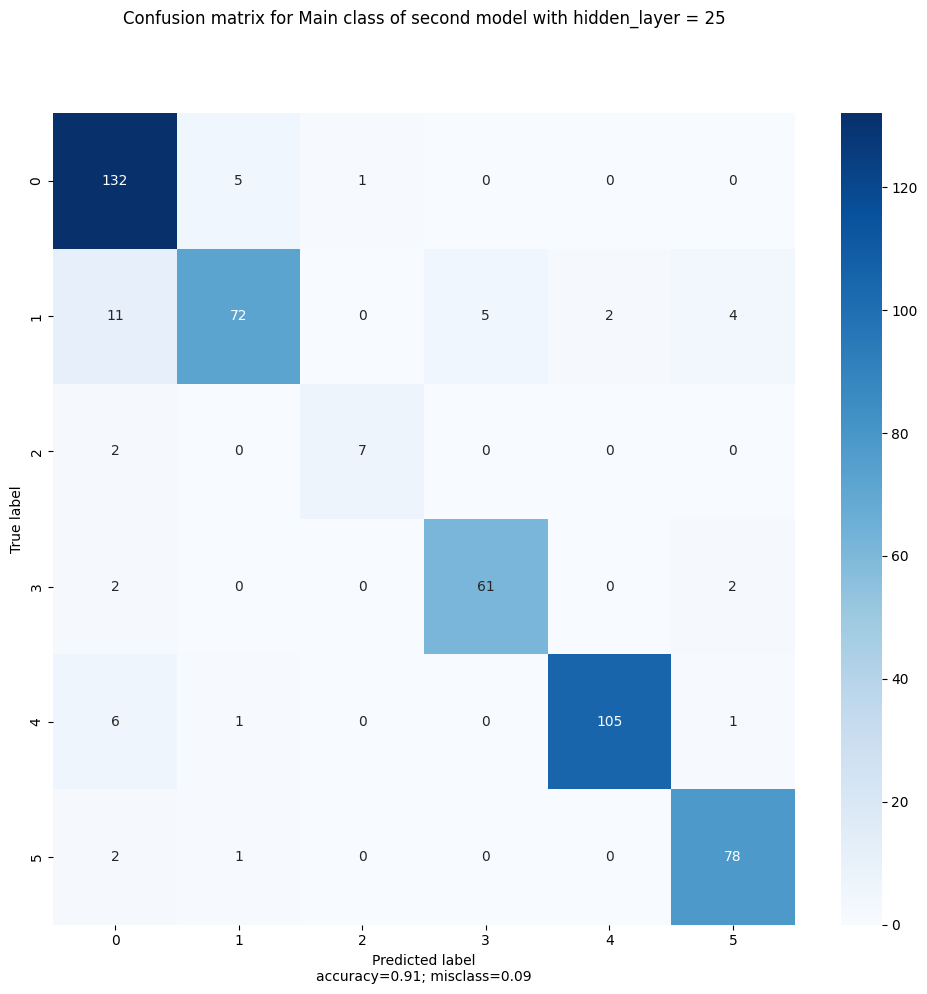

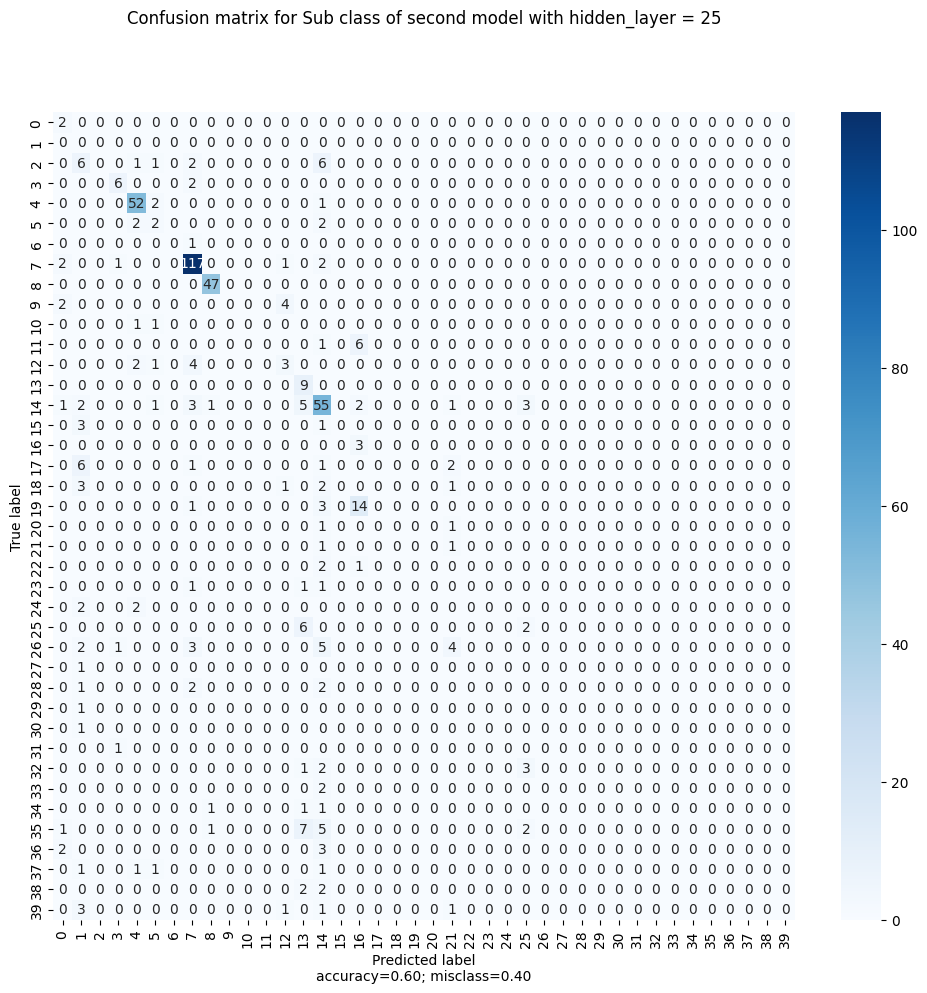

In [229]:
# testing the model with 25 hidden layers
Testing(model25, test_dataloader, 25)

<font color="#AF3B54"><h2>*Training with 100 hidden layes*</h2></font>


Training with 100 hidden layers for 50 epochs:

In [210]:
import torch.optim as optim
model100 = LSTM(dimension = 100).to('cuda')

## Optimizer and loss function
optimizer = optim.Adam(model100.parameters(),lr=0.001)
criterion = nn.BCELoss()
train_loss_coarse = []
train_loss_fine = []
train_acc_coarse = []
train_acc_fine = []

val_loss_coarse = []
val_loss_fine = []
val_acc_coarse = []
val_acc_fine = []
epochs = 50
for epoch in range(epochs):
  print("EPOCH {}/{} :".format(epoch +1, epochs))
  ## fit
  train_epoch_loss_coarse , train_epoch_acc_coarse, train_epoch_loss_fine, train_epoch_acc_fine= fit(model100, train_dataloader, optimizer, criterion)
  train_loss_coarse.append(train_epoch_loss_coarse)
  train_acc_coarse.append(train_epoch_acc_coarse)
  train_loss_fine.append(train_epoch_loss_fine)
  train_acc_fine.append(train_epoch_acc_fine)
  ## validation
  val_epoch_loss_coarse, val_epoch_acc_coarse, val_epoch_loss_fine, val_epoch_acc_fine= validation(model100, test_dataloader, criterion)
  val_loss_coarse.append(val_epoch_loss_coarse)
  val_acc_coarse.append(val_epoch_acc_coarse)
  val_loss_fine.append(val_epoch_loss_fine)
  val_acc_fine.append(val_epoch_acc_fine)

torch.save(model100.state_dict(), 'second_trained_model_100')

EPOCH 1/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 530.03it/s, val_acc_coarse=0.822, val_acc_fine=0.486, val_loss_coarse=0.184, val_loss_fine=0.0736]


EPOCH 2/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 721.58it/s, val_acc_coarse=0.862, val_acc_fine=0.446, val_loss_coarse=0.137, val_loss_fine=0.0677]


EPOCH 3/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 691.02it/s, val_acc_coarse=0.900, val_acc_fine=0.486, val_loss_coarse=0.0987, val_loss_fine=0.0623]


EPOCH 4/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 530.74it/s, val_acc_coarse=0.906, val_acc_fine=0.482, val_loss_coarse=0.0905, val_loss_fine=0.0608]


EPOCH 5/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 679.42it/s, val_acc_coarse=0.910, val_acc_fine=0.570, val_loss_coarse=0.0875, val_loss_fine=0.0549]


EPOCH 6/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 696.86it/s, val_acc_coarse=0.914, val_acc_fine=0.566, val_loss_coarse=0.0816, val_loss_fine=0.0505]


EPOCH 7/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 658.83it/s, val_acc_coarse=0.904, val_acc_fine=0.568, val_loss_coarse=0.0866, val_loss_fine=0.0503]


EPOCH 8/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 699.57it/s, val_acc_coarse=0.914, val_acc_fine=0.582, val_loss_coarse=0.09, val_loss_fine=0.0504]


EPOCH 9/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 665.04it/s, val_acc_coarse=0.928, val_acc_fine=0.588, val_loss_coarse=0.0684, val_loss_fine=0.046]


EPOCH 10/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 671.69it/s, val_acc_coarse=0.912, val_acc_fine=0.584, val_loss_coarse=0.0849, val_loss_fine=0.0449]


EPOCH 11/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 626.29it/s, val_acc_coarse=0.924, val_acc_fine=0.588, val_loss_coarse=0.083, val_loss_fine=0.0437]


EPOCH 12/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 545.63it/s, val_acc_coarse=0.918, val_acc_fine=0.598, val_loss_coarse=0.0805, val_loss_fine=0.0431]


EPOCH 13/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 699.02it/s, val_acc_coarse=0.918, val_acc_fine=0.612, val_loss_coarse=0.0987, val_loss_fine=0.0415]


EPOCH 14/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 704.32it/s, val_acc_coarse=0.924, val_acc_fine=0.622, val_loss_coarse=0.0779, val_loss_fine=0.0408]


EPOCH 15/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 590.52it/s, val_acc_coarse=0.918, val_acc_fine=0.622, val_loss_coarse=0.0887, val_loss_fine=0.0409]


EPOCH 16/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 683.11it/s, val_acc_coarse=0.920, val_acc_fine=0.610, val_loss_coarse=0.0881, val_loss_fine=0.0396]


EPOCH 17/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 695.63it/s, val_acc_coarse=0.922, val_acc_fine=0.634, val_loss_coarse=0.098, val_loss_fine=0.0391]


EPOCH 18/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 670.04it/s, val_acc_coarse=0.930, val_acc_fine=0.640, val_loss_coarse=0.0949, val_loss_fine=0.0364]


EPOCH 19/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 723.56it/s, val_acc_coarse=0.924, val_acc_fine=0.688, val_loss_coarse=0.0902, val_loss_fine=0.0368]


EPOCH 20/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 538.03it/s, val_acc_coarse=0.918, val_acc_fine=0.688, val_loss_coarse=0.105, val_loss_fine=0.0364] 


EPOCH 21/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 693.12it/s, val_acc_coarse=0.926, val_acc_fine=0.678, val_loss_coarse=0.0943, val_loss_fine=0.0365]


EPOCH 22/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 680.36it/s, val_acc_coarse=0.930, val_acc_fine=0.698, val_loss_coarse=0.097, val_loss_fine=0.0349]


EPOCH 23/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 492.09it/s, val_acc_coarse=0.924, val_acc_fine=0.684, val_loss_coarse=0.109, val_loss_fine=0.0367]


EPOCH 24/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 703.27it/s, val_acc_coarse=0.916, val_acc_fine=0.694, val_loss_coarse=0.101, val_loss_fine=0.0364]


EPOCH 25/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 707.70it/s, val_acc_coarse=0.908, val_acc_fine=0.666, val_loss_coarse=0.119, val_loss_fine=0.037]


EPOCH 26/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 682.38it/s, val_acc_coarse=0.920, val_acc_fine=0.692, val_loss_coarse=0.108, val_loss_fine=0.0349]


EPOCH 27/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 666.39it/s, val_acc_coarse=0.922, val_acc_fine=0.708, val_loss_coarse=0.103, val_loss_fine=0.0337]


EPOCH 28/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 474.60it/s, val_acc_coarse=0.918, val_acc_fine=0.708, val_loss_coarse=0.112, val_loss_fine=0.0337]


EPOCH 29/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 670.72it/s, val_acc_coarse=0.922, val_acc_fine=0.726, val_loss_coarse=0.123, val_loss_fine=0.0342]


EPOCH 30/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 729.42it/s, val_acc_coarse=0.916, val_acc_fine=0.724, val_loss_coarse=0.128, val_loss_fine=0.0335]


EPOCH 31/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 492.79it/s, val_acc_coarse=0.914, val_acc_fine=0.738, val_loss_coarse=0.128, val_loss_fine=0.0327]


EPOCH 32/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 683.49it/s, val_acc_coarse=0.922, val_acc_fine=0.738, val_loss_coarse=0.125, val_loss_fine=0.0326]


EPOCH 33/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 687.35it/s, val_acc_coarse=0.916, val_acc_fine=0.756, val_loss_coarse=0.126, val_loss_fine=0.0314]


EPOCH 34/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 671.47it/s, val_acc_coarse=0.910, val_acc_fine=0.730, val_loss_coarse=0.107, val_loss_fine=0.0323]


EPOCH 35/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 670.91it/s, val_acc_coarse=0.910, val_acc_fine=0.754, val_loss_coarse=0.128, val_loss_fine=0.0312]


EPOCH 36/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 265.89it/s, val_acc_coarse=0.918, val_acc_fine=0.758, val_loss_coarse=0.123, val_loss_fine=0.0314]


EPOCH 37/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 699.75it/s, val_acc_coarse=0.914, val_acc_fine=0.748, val_loss_coarse=0.121, val_loss_fine=0.0314]


EPOCH 38/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 681.47it/s, val_acc_coarse=0.918, val_acc_fine=0.752, val_loss_coarse=0.132, val_loss_fine=0.0315]


EPOCH 39/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 515.22it/s, val_acc_coarse=0.918, val_acc_fine=0.778, val_loss_coarse=0.13, val_loss_fine=0.0303] 


EPOCH 40/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 664.08it/s, val_acc_coarse=0.920, val_acc_fine=0.774, val_loss_coarse=0.12, val_loss_fine=0.0308] 


EPOCH 41/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 691.14it/s, val_acc_coarse=0.916, val_acc_fine=0.768, val_loss_coarse=0.111, val_loss_fine=0.029]


EPOCH 42/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 682.96it/s, val_acc_coarse=0.920, val_acc_fine=0.784, val_loss_coarse=0.111, val_loss_fine=0.0293]


EPOCH 43/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 656.55it/s, val_acc_coarse=0.924, val_acc_fine=0.762, val_loss_coarse=0.1, val_loss_fine=0.0303] 


EPOCH 44/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 443.64it/s, val_acc_coarse=0.918, val_acc_fine=0.788, val_loss_coarse=0.121, val_loss_fine=0.0303]


EPOCH 45/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 665.74it/s, val_acc_coarse=0.928, val_acc_fine=0.790, val_loss_coarse=0.115, val_loss_fine=0.0308]


EPOCH 46/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 658.18it/s, val_acc_coarse=0.912, val_acc_fine=0.790, val_loss_coarse=0.141, val_loss_fine=0.0301]


EPOCH 47/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 509.71it/s, val_acc_coarse=0.920, val_acc_fine=0.774, val_loss_coarse=0.122, val_loss_fine=0.0311]


EPOCH 48/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 692.30it/s, val_acc_coarse=0.914, val_acc_fine=0.790, val_loss_coarse=0.121, val_loss_fine=0.0302]


EPOCH 49/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 678.76it/s, val_acc_coarse=0.906, val_acc_fine=0.774, val_loss_coarse=0.134, val_loss_fine=0.0322]


EPOCH 50/50 :


  test: 100%|██████████| 125/125 [00:00<00:00, 686.25it/s, val_acc_coarse=0.920, val_acc_fine=0.800, val_loss_coarse=0.119, val_loss_fine=0.0287]


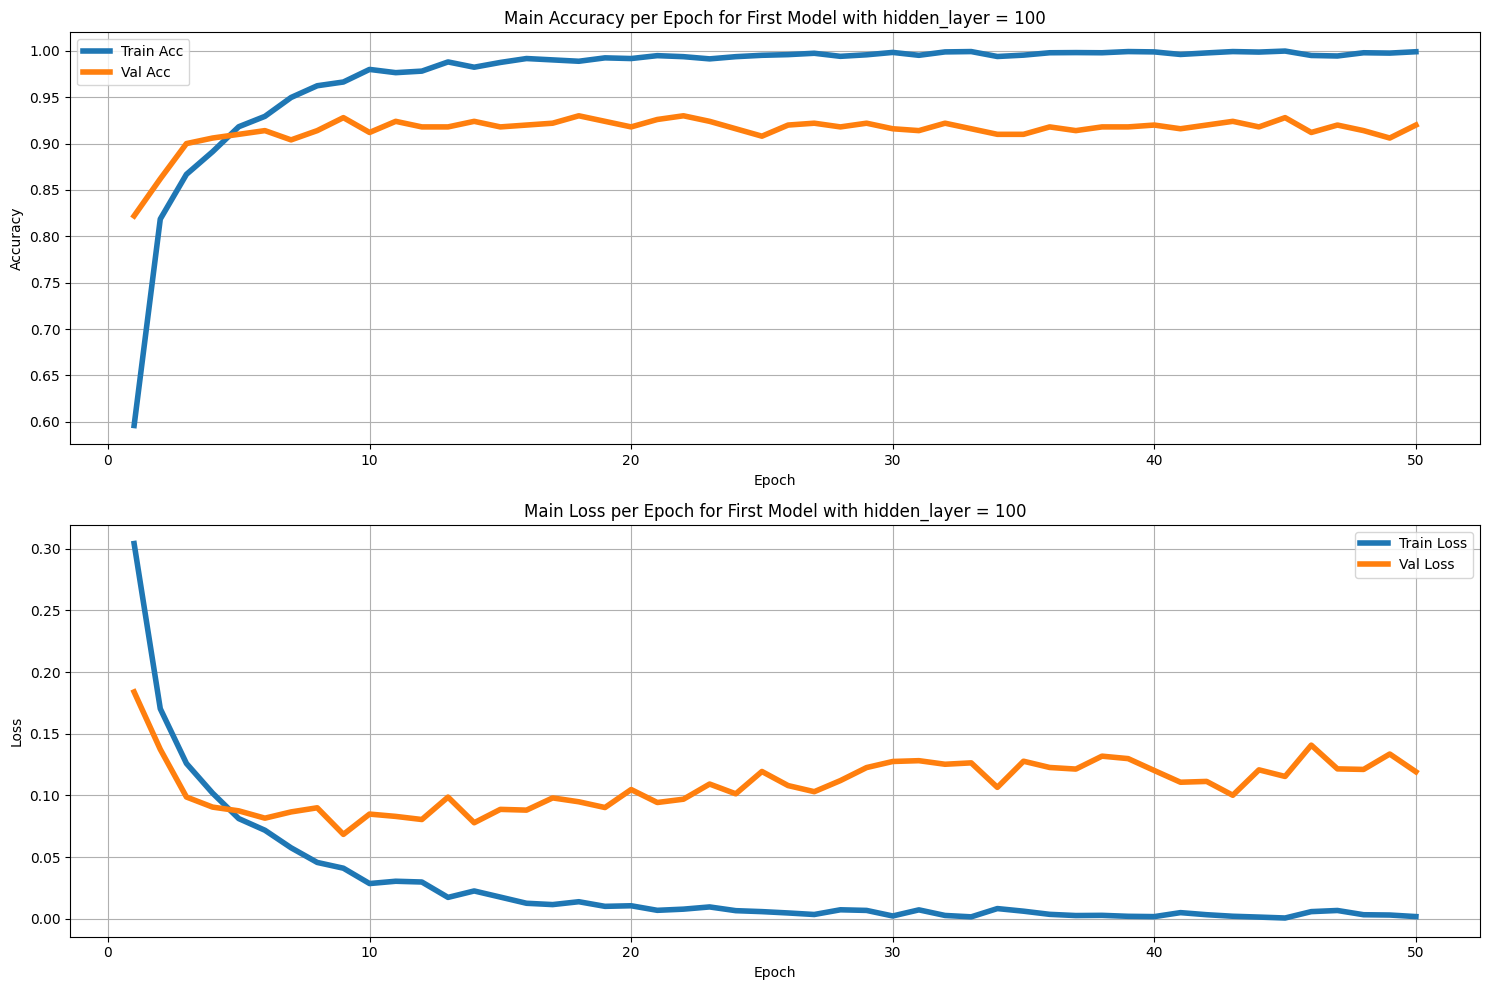

In [211]:
# Main classification
plot_acc_loss(train_acc_coarse, val_acc_coarse, train_loss_coarse, val_loss_coarse, 100, 'Main')

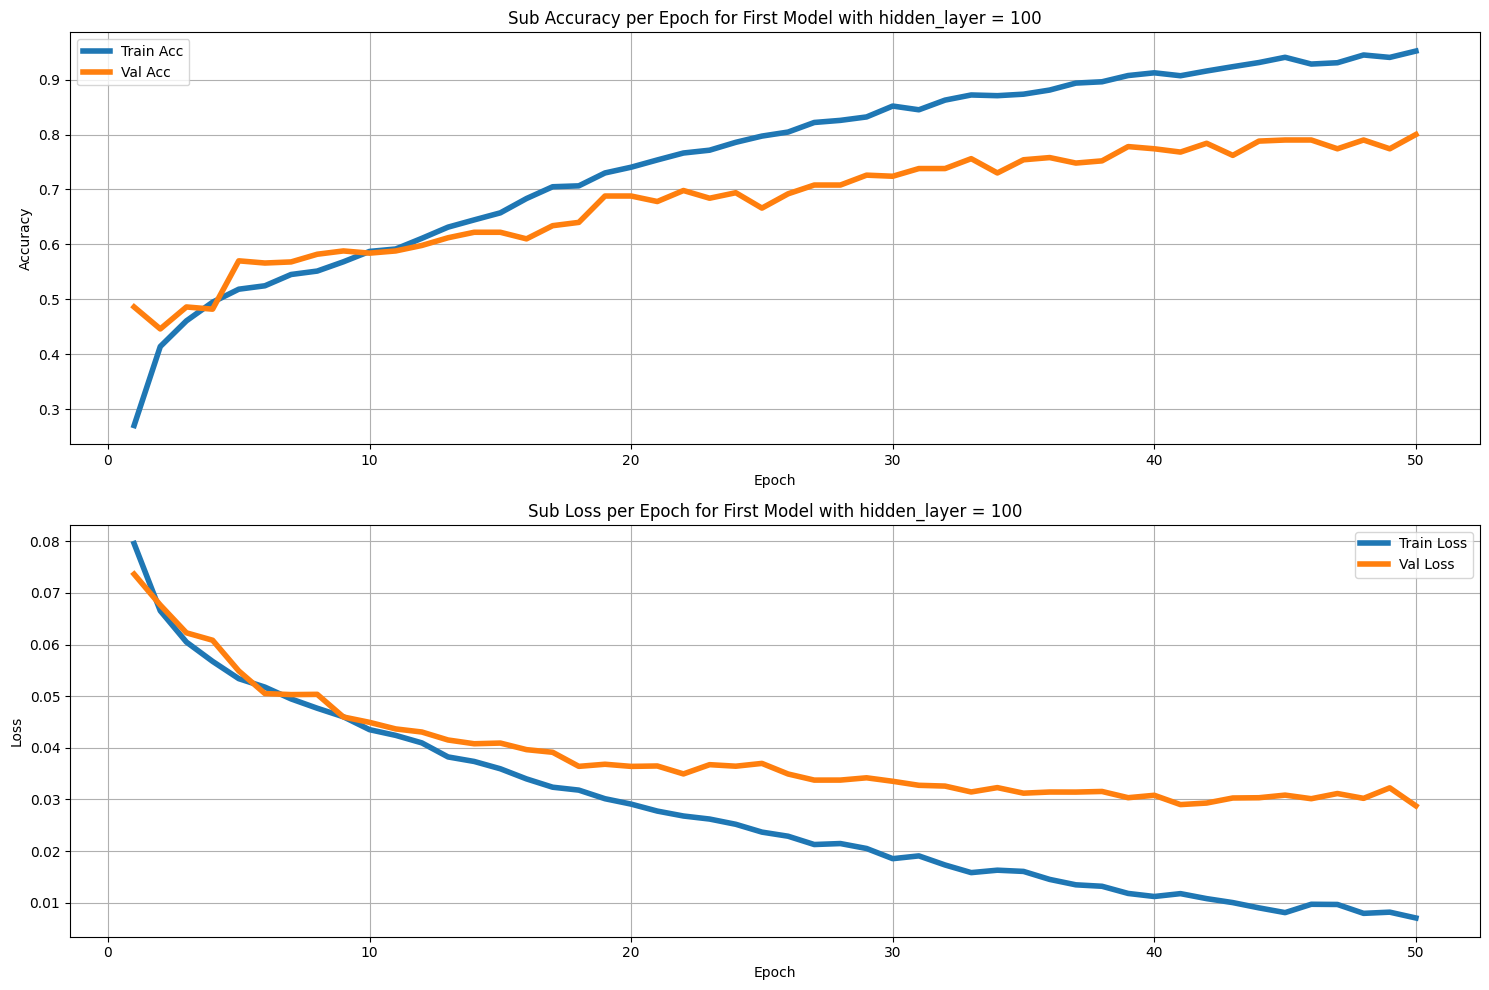

In [212]:
# Sub classification
plot_acc_loss(train_acc_fine, val_acc_fine, train_loss_fine, val_loss_fine, 100, 'Sub')

   test: 100%|██████████| 125/125 [00:00<00:00, 713.36it/s]


              precision    recall  f1-score   support

           0     0.8958    0.9348    0.9149       138
           1     0.9375    0.7979    0.8621        94
           2     0.7000    0.7778    0.7368         9
           3     0.9394    0.9538    0.9466        65
           4     0.9474    0.9558    0.9515       113
           5     0.9186    0.9753    0.9461        81

    accuracy                         0.9200       500
   macro avg     0.8898    0.8992    0.8930       500
weighted avg     0.9211    0.9200    0.9192       500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     0.0000    0.0000    0.0000         0
           2     1.0000    0.5625    0.7200        16
           3     0.6000    0.7500    0.6667         8
           4     1.0000    0.9818    0.9908        55
           5     0.4444    0.6667    0.5333         6
           6     0.0000    0.0000    0.0000         1
           7     0.9062    0.9431    0.9243       123
           8     0.9792    1.0000    0.9895        47
           9     0.8333    0.8333    0.8333         6
          10     0.0000    0.0000    0.0000         2
          11     0.7778    1.0000    0.8750         7
          12     0.6154    0.8000    0.6957        10
          13     0.8182    1.0000    0.9000         9
          14     0.6818    0.8108    0.7407        74
          17     0.5714    1.0000    0.7273         4
          18     1.0000    1.0000    1.0000         3
          19     1.0000    

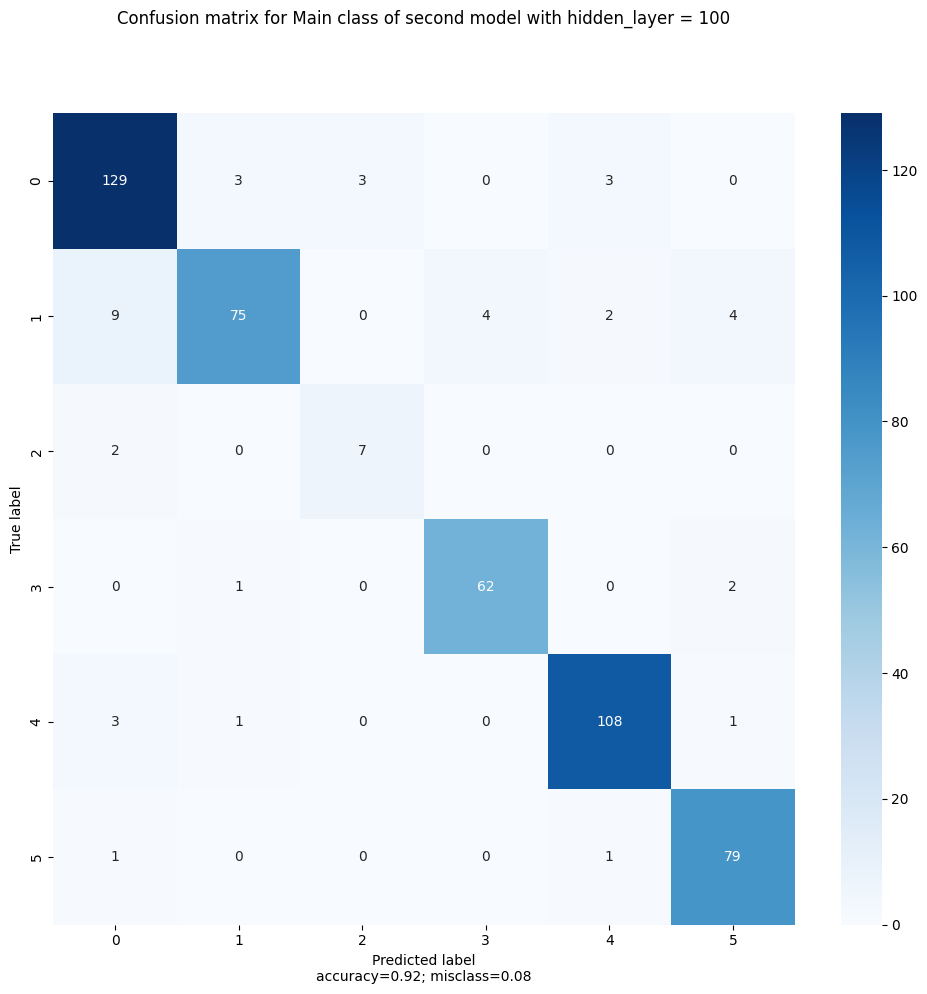

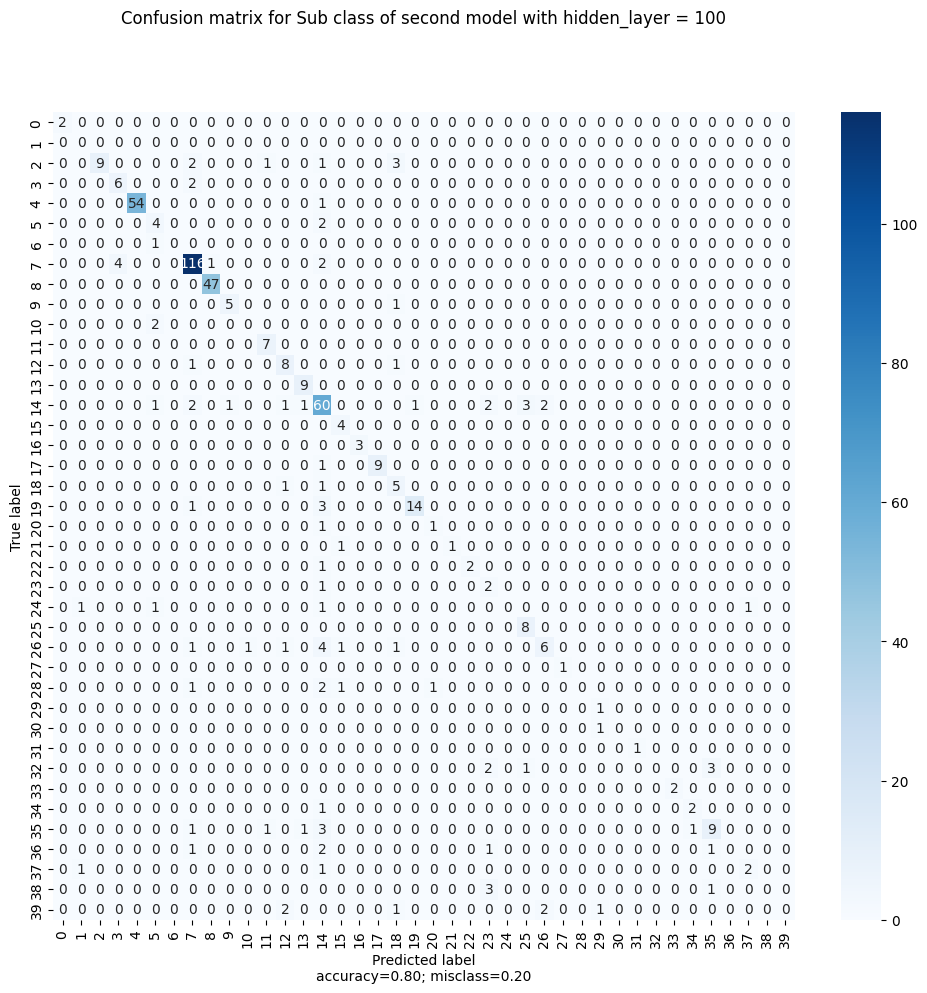

In [213]:
# testing the model with 100 hidden layers
Testing(model100, test_dataloader, 100)